In [1434]:
import numpy as np
from scipy.spatial import KDTree
import random
import math
import copy
import matplotlib.pyplot as plt

In [1435]:
# dijkstra algo with nested dict
graph = {
    'a':{'b':3, 'c':2, 'd':7},
    'b':{'c':1, 'f':5},
    'c':{'f':6, 'd':2},
    'd':{'e':3, 'g':6},
    'e':{'g':3, 'h':4},
    'f':{'e':1, 'h':8},
    'g':{'h':2},
    'h':{'g':2}
}
def dijkstra(graph, start, goal):
    shortest_dist = {}
    predecessor = {}
    nodes = graph
    path = []
    
    # set cost of start = 0 and the rest to infinity
    for node in nodes:
        shortest_dist[node] = np.inf
    shortest_dist[start] = 0
    
    # loop through the vertices
    while nodes:
        min_dist_node = None
        for node in nodes:
            if min_dist_node is None:
                min_dist_node = node
            elif shortest_dist[node] < shortest_dist[min_dist_node]:
                min_dist_node = node
            print("expanding node ", min_dist_node)
            
        path_options = graph[min_dist_node].items() # get vertex and cost of min_dist_node
        print("path options are ", path_options)
        
        # check for smallest path with neighbors
        for child_node, weight in path_options:
            
            total_cost = weight + shortest_dist[min_dist_node]
            print("exploring node", child_node, ", current cost is", weight, 
                  ", previous cost is", shortest_dist[min_dist_node], ", total cost is ", total_cost)
            # print("current cost is", weight)
            # print("previous cost is", shortest_dist[min_dist_node])
            
            if total_cost < shortest_dist[child_node]:
                shortest_dist[child_node] = total_cost
                predecessor[child_node] = min_dist_node
           
        nodes.pop(min_dist_node)
        print("remove node", min_dist_node)
    
    currentNode = goal
    while currentNode != start:
        try:
            path.insert(0, currentNode)
            # print(path)
            currentNode = predecessor[currentNode]
        except KeyError:
            print("Path in not reachable")
            break
    
    path.insert(0, start)
    
    if shortest_dist[goal] != np.inf:
        print("Shortest distance is " + str(shortest_dist[goal]))
        print("Optimal path is" + str(path))

In [1436]:
dijkstra(graph, 'a', 'h')

expanding node  a
expanding node  a
expanding node  a
expanding node  a
expanding node  a
expanding node  a
expanding node  a
expanding node  a
path options are  dict_items([('b', 3), ('c', 2), ('d', 7)])
exploring node b , current cost is 3 , previous cost is 0 , total cost is  3
exploring node c , current cost is 2 , previous cost is 0 , total cost is  2
exploring node d , current cost is 7 , previous cost is 0 , total cost is  7
remove node a
expanding node  b
expanding node  c
expanding node  c
expanding node  c
expanding node  c
expanding node  c
expanding node  c
path options are  dict_items([('f', 6), ('d', 2)])
exploring node f , current cost is 6 , previous cost is 2 , total cost is  8
exploring node d , current cost is 2 , previous cost is 2 , total cost is  4
remove node c
expanding node  b
expanding node  b
expanding node  b
expanding node  b
expanding node  b
expanding node  b
path options are  dict_items([('c', 1), ('f', 5)])
exploring node c , current cost is 1 , previou

In [1437]:
def is_collision(curr_x, curr_y, target_x, target_y, robot_radius, obstacle_kd_tree, transform):
    x = curr_x
    y = curr_y
    dx = target_x - curr_x
    dy = target_y - curr_y
    yaw = math.atan2(target_y - curr_y, target_x - curr_x)
    # yaw = transform.rotation.yaw
    d = np.sqrt(dx ** 2 + dy ** 2)

    #if d >= 30:
    #    return True

    D = robot_radius
    n_step = round(d / D)

    for i in range(n_step):
        dist, _ = obstacle_kd_tree.query([x, y])
        if dist <= robot_radius:
            return True  # collision
        x += D * math.cos(yaw)
        y += D * math.sin(yaw)

    # goal point check
    dist, _ = obstacle_kd_tree.query([target_x, target_y])
    if dist <= robot_radius:
        return True  # collision

    return False  # OK

def generate_road_map(sample_x, sample_y, robot_radius, obstacle_kd_tree, transform):
    road_map = []
    n_sample = len(sample_x)
    sample_kd_tree = KDTree(np.vstack((sample_x, sample_y)).T)
    # print('sample tree is \n', np.vstack((sample_x, sample_y)).T)
    for (i, ix, iy) in zip(range(n_sample), sample_x, sample_y):
        dists, indexes = sample_kd_tree.query([ix, iy], k=n_sample)
        # print(dists, indexes)
        edge_id = []

        for ii in range(1, len(indexes)):
            nx = sample_x[indexes[ii]]
            ny = sample_y[indexes[ii]]

            if not is_collision(ix, iy, nx, ny, robot_radius, obstacle_kd_tree, transform):
                edge_id.append(indexes[ii])

            if len(edge_id) >= 10:
                break

        road_map.append(edge_id)
    return road_map

def sample_points(curr_x, curr_y, target_x, target_y, robot_radius, obs_x, obs_y, obs_KDTree, rng, transform, sample_length):

    max_x = max(obs_x)
    max_y = max(obs_y)
    min_x = min(obs_x)
    min_y = min(obs_y)

    sample_x, sample_y = [], []

    if rng is None:
        rng = np.random.default_rng()

    while len(sample_x) <= sample_length:
        temp_x = (rng.random() * (max_x - min_x)) + min_x
        temp_y = (rng.random() * (max_y - min_y)) + min_y

        dist, index = obs_KDTree.query([temp_x, temp_y]) #find closest dist and index to temp

        if dist >= robot_radius:
            sample_x.append(temp_x)
            sample_y.append(temp_y)

    sample_x.append(curr_x)
    sample_y.append(curr_y)
    sample_x.append(target_x)
    sample_y.append(target_y)

    return sample_x, sample_y

class Node:
    """
    Node class for dijkstra search
    """
    def __init__(self, x, y, cost, parent_index):
        self.x = x
        self.y = y
        self.cost = cost
        self.parent_index = parent_index

def dijkstra(curr_x, curr_y, target_x, target_y, road_map, sample_x, sample_y, transform):

    # Node(x, y, cost, parent_index)
    start_node = Node(curr_x, curr_y, 0.0, -1)
    #print("start node is", start_node.x)
    goal_node = Node(target_x, target_y, 0.0, -1)

    open_set, closed_set = {}, {}
    open_set[len(road_map) - 2] = start_node
    

    path_found = True

    while True:
        # if not open_set:
        mykeys = list(open_set.keys())
        # print('mykeys are', mykeys)
        
        if len(open_set) == 0:
            # print(open_set[mykeys[0]])
            # print('length of openset is ', len(open_set))
            print("Cannot find path")
            path_found = False
            break

        c_id = min(open_set, key=lambda o: open_set[o].cost)
        '''
        min_cost = np.inf
        for i in range(len(open_set)):
            key = list(open_set.keys())[i]
            cost = open_set[key].cost
            if cost < min_cost:
                min_cost = cost
                c_id = key
        '''
        current = open_set[c_id]

        if c_id == (len(road_map) - 1):
            print("goal is found!")
            goal_node.parent_index = current.parent_index
            goal_node.cost = current.cost
            break

        # Remove the item from the open set
        # print("my deleted key is ", c_id)
        del open_set[c_id]
        # Add it to the closed set
        closed_set[c_id] = current

        # expand search grid based on motion model
        for i in range(len(road_map[c_id])):
            n_id = road_map[c_id][i]
            dx = sample_x[n_id] - current.x
            dy = sample_y[n_id] - current.y
            d = math.hypot(dx, dy)
            node = Node(sample_x[n_id], sample_y[n_id],
                        current.cost + d, c_id)

            if n_id in closed_set:
                continue
            # Otherwise if it is already in the open set
            if n_id in open_set:
                if open_set[n_id].cost > node.cost:
                    open_set[n_id].cost = node.cost
                    open_set[n_id].parent_index = c_id
            else:
                open_set[n_id] = node

    if path_found is False:
        return []

    # generate final course
    # path = [[goal_node.x, goal_node.y, 0]]
    path = [[goal_node.x, goal_node.y]]
    parent_index = goal_node.parent_index
    while parent_index != -1:
        n = closed_set[parent_index]
        # path.append([n.x, n.y, 0])
        path.append([n.x, n.y])
        parent_index = n.parent_index

    return path

In [1438]:
"""
# sample_x = np.random.randint(100, size=500)
# sample_y = np.random.randint(100, size=500)

curr_x, curr_y = np.random.randint(10), np.random.randint(10)
target_x, target_y = np.random.randint(90), np.random.randint(90)
obs_size = 10
obs_x = np.random.randint(100, size=obs_size)
obs_y = np.random.randint(100, size=obs_size)
transform = 1
robot_radius = 2.35
obstacle_kd_tree = KDTree(np.vstack((obs_x, obs_y)).T) # vertical stack then transpose

sample_x, sample_y = sample_points(curr_x, curr_y, target_x, target_y, robot_radius, obs_x, obs_y, obstacle_kd_tree, None, transform)

# print("obstacle is \n", np.vstack((obs_x, obs_y)).T)
# print("roadmap is \n", generate_road_map(sample_x, sample_y, robot_radius, obstacle_kd_tree, transform))
roadmap = generate_road_map(sample_x, sample_y, robot_radius, obstacle_kd_tree, transform)
road_map = roadmap

paths = dijkstra(curr_x, curr_y, target_x, target_y, road_map, sample_x, sample_y, transform)
print(paths)
print("length of new waypoints is", len(paths))
"""

'\n# sample_x = np.random.randint(100, size=500)\n# sample_y = np.random.randint(100, size=500)\n\ncurr_x, curr_y = np.random.randint(10), np.random.randint(10)\ntarget_x, target_y = np.random.randint(90), np.random.randint(90)\nobs_size = 10\nobs_x = np.random.randint(100, size=obs_size)\nobs_y = np.random.randint(100, size=obs_size)\ntransform = 1\nrobot_radius = 2.35\nobstacle_kd_tree = KDTree(np.vstack((obs_x, obs_y)).T) # vertical stack then transpose\n\nsample_x, sample_y = sample_points(curr_x, curr_y, target_x, target_y, robot_radius, obs_x, obs_y, obstacle_kd_tree, None, transform)\n\n# print("obstacle is \n", np.vstack((obs_x, obs_y)).T)\n# print("roadmap is \n", generate_road_map(sample_x, sample_y, robot_radius, obstacle_kd_tree, transform))\nroadmap = generate_road_map(sample_x, sample_y, robot_radius, obstacle_kd_tree, transform)\nroad_map = roadmap\n\npaths = dijkstra(curr_x, curr_y, target_x, target_y, road_map, sample_x, sample_y, transform)\nprint(paths)\nprint("lengt

In [1439]:
'''
# plotting

print("start = red, goal = green, obstacles = black, edge = blue")
plot_x, plot_y = [], []
for path in paths:
    plot_x.append(path[0])
    plot_y.append(path[1])
plt.plot(plot_x, plot_y, color='blue')
plt.scatter(plot_x[1:-1], plot_y[1:-1], color='blue')
plt.scatter(plot_x[0], plot_y[0], color='green')
plt.scatter(plot_x[-1], plot_y[-1], color='red')
plt.scatter(obs_x, obs_y, color='black')
#plt.scatter(sample_x, sample_y, color='yellow')
plt.grid()
plt.tight_layout()
'''

'\n# plotting\n\nprint("start = red, goal = green, obstacles = black, edge = blue")\nplot_x, plot_y = [], []\nfor path in paths:\n    plot_x.append(path[0])\n    plot_y.append(path[1])\nplt.plot(plot_x, plot_y, color=\'blue\')\nplt.scatter(plot_x[1:-1], plot_y[1:-1], color=\'blue\')\nplt.scatter(plot_x[0], plot_y[0], color=\'green\')\nplt.scatter(plot_x[-1], plot_y[-1], color=\'red\')\nplt.scatter(obs_x, obs_y, color=\'black\')\n#plt.scatter(sample_x, sample_y, color=\'yellow\')\nplt.grid()\nplt.tight_layout()\n'

In [1440]:
def prm(curr_x, curr_y, target_x, target_y, filtered_obstacles, robot_radius, transform, obs_x, obs_y):
        # robot_radius = 2.35
        rng = None
        paths = []


        obs_KDTree = KDTree(np.vstack((obs_x, obs_y)).T) # vertical stack then transpose
        # obs_KDTree = KDTree(np.vstack((obs_x, obs_y))) # vertical stack then transpose

        if (len(obs_x) == 0 and len(obs_y) == 0):
            return paths

        sample_x, sample_y = sample_points(curr_x, curr_y, target_x, target_y, robot_radius, obs_x, obs_y, obs_KDTree, rng, transform, sample_length)

        road_map = generate_road_map(sample_x, sample_y,robot_radius, obs_KDTree, transform)

        paths = dijkstra(curr_x, curr_y, target_x, target_y, road_map, sample_x, sample_y, transform)
        
        # print('new path is', paths)
        
        
        return paths, sample_x, sample_y, road_map

distance to obstacle is 2.8284271247461903
goal is found!
num of prm 1
checking...... True


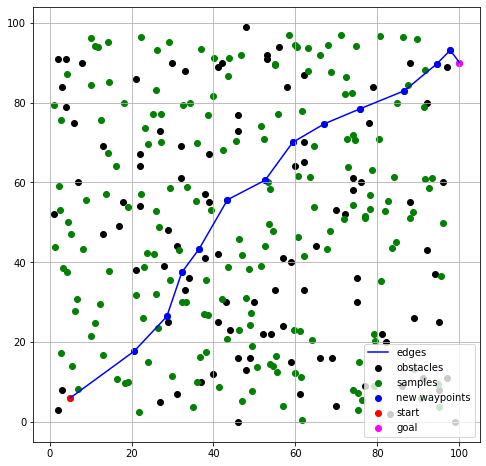

In [1441]:
filtered_obstacles = None
waypoints = [[15, 9], [30, 40], [60, 89], [100, 90]]
sample_length = 200

obs_size = 100
obs_x = np.random.randint(100, size=obs_size)
obs_y = np.random.randint(100, size=obs_size)
transform = 1 
robot_radius = 1
obstacle_kd_tree = KDTree(np.vstack((obs_x, obs_y)).T) # vertical stack then transpose

target_x, target_y = waypoints[-1]
waypoint_x, waypoint_y = [], []
'''
plt.figure()
plt.grid()
plt.tight_layout()
for waypoint in waypoints: 
    waypoint_x = waypoint[0]
    waypoint_y = waypoint[1]
    plt.scatter(waypoint_x, waypoint_y, color='yellow')
'''
# print('original waypoints is ', waypoints)

'''
obs_x = []
obs_y = []
for i in range(len(filtered_obstacles)):
    obs_x.append(filtered_obstacles[i].get_location().x)
    obs_y.append(filtered_obstacles[i].get_location().y)
'''

distance = np.inf
curr_x, curr_y = 5, 6
for i in range(len(obs_x)):
    temp_d = math.sqrt((curr_x - obs_x[i])**2 + (curr_y-obs_y[i])**2)  #fku lugou
    if temp_d < distance:
        distance = temp_d
print('distance to obstacle is', distance)

#for waypoint in waypoints:
target_x, target_y = waypoints[-1]
if distance <= 30: # 30: the distance from the closest obstacle to start avoiding program
    i = 1
    new_waypoints = copy.deepcopy(waypoints)
    paths, sample_x, sample_y, road_map = prm(curr_x=curr_x, curr_y=curr_y, target_x=target_x, target_y=target_y, filtered_obstacles=filtered_obstacles, robot_radius=robot_radius, transform=transform, obs_x=obs_x, obs_y=obs_y)
    while len(paths) == 0:
        i += 1
        paths, sample_x, sample_y, road_map = prm(curr_x=curr_x, curr_y=curr_y, target_x=target_x, target_y=target_y, filtered_obstacles=filtered_obstacles, robot_radius=robot_radius, transform=transform, obs_x=obs_x, obs_y=obs_y)
    # curr_x, curr_y = paths[0]
    print('num of prm', i)
    plot_x, plot_y = [], []
    for path in paths:
        plot_x.append(path[0])
        plot_y.append(path[1])
    
    print("checking......", paths[-1]==[curr_x, curr_y])
    plt.figure(figsize=(8,8))
    # plt.scatter(plot_x[0], plot_y[0], color='green')
    plt.scatter(obs_x, obs_y, color='black', label='obstacles') #obstacles
    plt.scatter(sample_x, sample_y, color='green', label='samples')
    plt.plot(plot_x, plot_y, color='blue', label='edges')
    plt.scatter(plot_x[1:-1], plot_y[1:-1], color='blue', label='new waypoints') #new waypoints
    plt.scatter(plot_x[-1], plot_y[-1], color='red', label='start') #start
    plt.scatter(plot_x[0], plot_y[0], color='magenta', label='goal') #start
    plt.legend()
    plt.grid()
    if len(paths) != 0:
        new_waypoints.remove(waypoints[0])
        for path in paths:
            new_waypoints.insert(0, path)
else:
    temp_x = []
    temp_y = []
    for i in range(len(waypoints)):
        temp_x.append(waypoints[i][0])
        temp_y.append(waypoints[i][1])
    plt.plot(temp_x, temp_y, color='blue')

In [1442]:
print('waypoint is ', waypoints)
print('length of roadmap is', len(road_map[0]))
print('length of sample_x is ', len(sample_x))
print('goal is', paths[0], 'start is', paths[-1])
print('goal is', [target_x, target_y], 'start is', [curr_x, curr_y])

waypoint is  [[15, 9], [30, 40], [60, 89], [100, 90]]
length of roadmap is 10
length of sample_x is  203
goal is [100, 90] start is [5, 6]
goal is [100, 90] start is [5, 6]


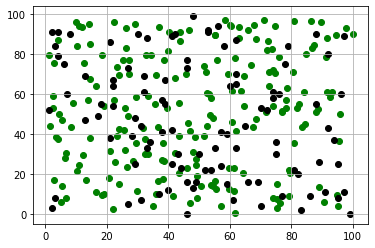

In [1444]:
plt.scatter(sample_x, sample_y, color='green')
plt.scatter(obs_x, obs_y, color='black')
plt.grid()

(100, 2)


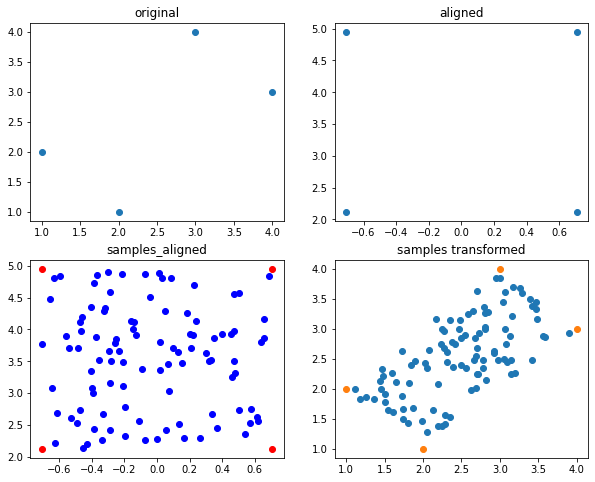

In [1425]:
# sampling with rotation matrix
a = np.array([2,1])
b = np.array([3,4])
c = np.array([1,2])
d = np.array([4,3])
x = [2,3,1,4]
y = [1,4,2,3]
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.title('original')
plt.scatter(x,y)
theta = np.arctan((3-1)/(4-2))
def rot(theta):
    return np.array([[np.cos(theta), -np.sin(theta)],
                     [np.sin(theta), np.cos(theta)]])
a, b, c, d = rot(theta) @ a, rot(theta) @ b, rot(theta) @ c, rot(theta) @ d
# a, b, c, d = rot
plot_x = [a[0],b[0],c[0],d[0]]
plot_y = [a[1],b[1],c[1],d[1]]
plt.subplot(2,2,2)
plt.title('aligned')
plt.scatter(plot_x, plot_y)
sample_x = np.random.uniform(min(plot_x), max(plot_x), size=100)
sample_y = np.random.uniform(min(plot_y), max(plot_y), size=100)
plt.subplot(2,2,3)
plt.title('samples_aligned')
plt.scatter(sample_x, sample_y, color='blue')
plt.scatter(plot_x, plot_y, color='red')
sample = np.zeros((100, 2))
print(sample.shape)
for i in range(len(sample_x)):
    temp = np.array([sample_x[i], sample_y[i]])
    sample[i] = np.linalg.pinv(rot(theta)) @ temp
plt.subplot(2,2,4)
plt.title('samples transformed')
plt.scatter(sample[:, 0], sample[:, 1])
plt.scatter(x, y)

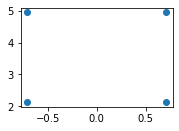

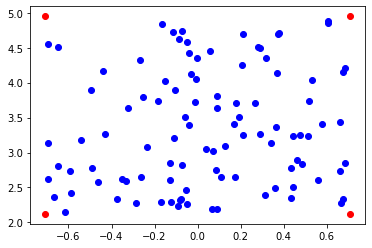

In [1153]:
sample_x = np.random.uniform(min(plot_x), max(plot_x), size=100)
sample_y = np.random.uniform(min(plot_y), max(plot_y), size=100)
plt.scatter(sample_x, sample_y, color='blue')
plt.scatter(plot_x, plot_y, color='red')

(100, 2)


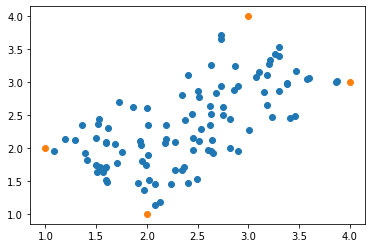

In [1154]:
sample = np.zeros((100, 2))
print(sample.shape)
for i in range(len(sample_x)):
    temp = np.array([sample_x[i], sample_y[i]])
    sample[i] = np.linalg.pinv(rot(theta)) @ temp
plt.scatter(sample[:, 0], sample[:, 1])
plt.scatter(x, y)

In [1412]:
a=[1,2,3]


In [1413]:
a[1:-1]

[2]

In [1433]:
np.arctan(0/-10)

-0.0

In [ ]:
np